In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Tennis Win Prediction

The Association of Tennis Professionals (ATP) is the sport governing body of tennis for men’s professional tennis competitions in the world. Statistics of all matches in the ATP competitions are recorded annually including the match location, match draw size, player’s statistics etc. 

<img src="download.png" width = "200"/>

Our target dataset of interest is the list of ATP tennis matches from the year 2022 in the world. Since many factors - age, height, or seed (a player’s ranking based on past performances) can determine the prospect of a player’s match win or loss, our analysis aims to study a specific player’s statistics to predict the win-loss probability of that player against other players. Our chosen study target is Felix Auger Aliassime, a current tennis player who has played the most matches in 2022. We will be examining the effect of his opponents’ age, height or seed to Felix’s win rate. Therefore, through this project, we will be answering the question: Within the year 2022, how likely is Felix Auger Aliassime to win against another tennis player in the world based on that opponent’s age, height, and seed?

### Preliminary Data Analaysis:

##### Taking Data from the Web:

In [2]:
url <- "https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2022.csv"
destfile <- "data/atp_matches_2022.csv"
download.file(url, destfile)
tennis_data <- read_csv("data/atp_matches_2022.csv")
tennis_data

Rows: 2917 Columns: 49
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): tourney_id, tourney_name, surface, tourney_level, winner_entry, wi...
dbl (35): draw_size, tourney_date, match_num, winner_id, winner_seed, winner...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2022-8888,Atp Cup,Hard,16,A,20220103,300,200000,NA,NA,⋯,50,32,7,10,3,5,11,3308,19,2260
2022-8888,Atp Cup,Hard,16,A,20220103,299,133430,NA,NA,⋯,33,21,8,9,3,6,14,2475,20,2230
2022-8888,Atp Cup,Hard,16,A,20220103,298,105138,NA,NA,⋯,80,62,20,16,6,7,19,2260,9,3706
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2022-M-DC-2022-WG2-PO-HKG-BEN-01,Davis Cup WG2 PO: HKG vs BEN,Hard,4,D,20220304,1,138846,NA,NA,⋯,54,29,8,11,6,10,1059,10,1881,1
2022-M-DC-2022-WG2-PO-HKG-BEN-01,Davis Cup WG2 PO: HKG vs BEN,Hard,4,D,20220304,2,209409,NA,NA,⋯,39,24,7,10,5,9,NA,NA,NA,NA
2022-M-DC-2022-WG2-PO-HKG-BEN-01,Davis Cup WG2 PO: HKG vs BEN,Hard,4,D,20220304,4,208414,NA,NA,⋯,34,24,13,10,5,8,NA,NA,NA,NA


##### Cleaning and Wrangling our Data into Tidy Format and a Bit More for our Purposes:

### Methods:

### Expected outcomes and significance:

In [3]:
# We need to pick a person who plays the most matches in the year:
player_with_most_played_matches_2022 <- tennis_data |>
    select(winner_name, loser_name) |>
    pivot_longer(winner_name:loser_name, names_to = "Winner or Loser", values_to = "name") |>
    select(name) |>
    group_by(name) |>
    summarize(number_of_matches_played = n()) |>
    arrange(-number_of_matches_played) |>
    slice(1)

player_with_most_played_matches_2022

#Felix Auger Aliassime has the most matches played in 2022 with a record of 87. 

name,number_of_matches_played
<chr>,<int>
Felix Auger Aliassime,87


In [4]:
#Tidy the data for this player, win or lose:
win_pov_tennis_data <- tennis_data |>
    filter(winner_name == "Felix Auger Aliassime") |>
    select(winner_name, loser_age, loser_seed, loser_ht) |>
    mutate(winner = "Yes") |>
    rename(name = winner_name, opp_age = loser_age, opp_seed = loser_seed, opp_ht = loser_ht)

loser_pov_tennis_data <- tennis_data |>
    filter(loser_name == "Felix Auger Aliassime") |>
    select(loser_name, winner_age, winner_seed, winner_ht) |>
    mutate(winner = "No") |>
    rename(name = loser_name, opp_age = winner_age, opp_seed = winner_seed, opp_ht = winner_ht)


somewhat_tidy_tennis_data_2022 <- rbind(win_pov_tennis_data, loser_pov_tennis_data)

tidy_tennis_data_2022 <- somewhat_tidy_tennis_data_2022 |>
    filter(!is.na(opp_seed))

tidy_tennis_data_2022

tidy_tennis_data_2022_scaled <- recipe(winner ~ opp_age + opp_ht + opp_seed, data = tidy_tennis_data_2022) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) |>
  prep() |>
  bake(tidy_tennis_data_2022)
tidy_tennis_data_2022_scaled 

name,opp_age,opp_seed,opp_ht,winner
<chr>,<dbl>,<dbl>,<dbl>,<chr>
Felix Auger Aliassime,31.6,24,175,Yes
Felix Auger Aliassime,33.3,27,198,Yes
Felix Auger Aliassime,23.4,1,193,Yes
⋮,⋮,⋮,⋮,⋮
Felix Auger Aliassime,23.6,4,183,No
Felix Auger Aliassime,23.8,3,183,No
Felix Auger Aliassime,25.0,8,193,No


opp_age,opp_ht,opp_seed,winner
<dbl>,<dbl>,<dbl>,<fct>
1.1244935,-1.8753088,2.6935901,Yes
1.4840105,1.4250368,3.1613393,Yes
-0.6096476,0.7075703,-0.8924869,Yes
⋮,⋮,⋮,⋮
-0.5673514,-0.7273625,-0.4247378,No
-0.5250553,-0.7273625,-0.5806542,No
-0.2712786,0.7075703,0.1989278,No


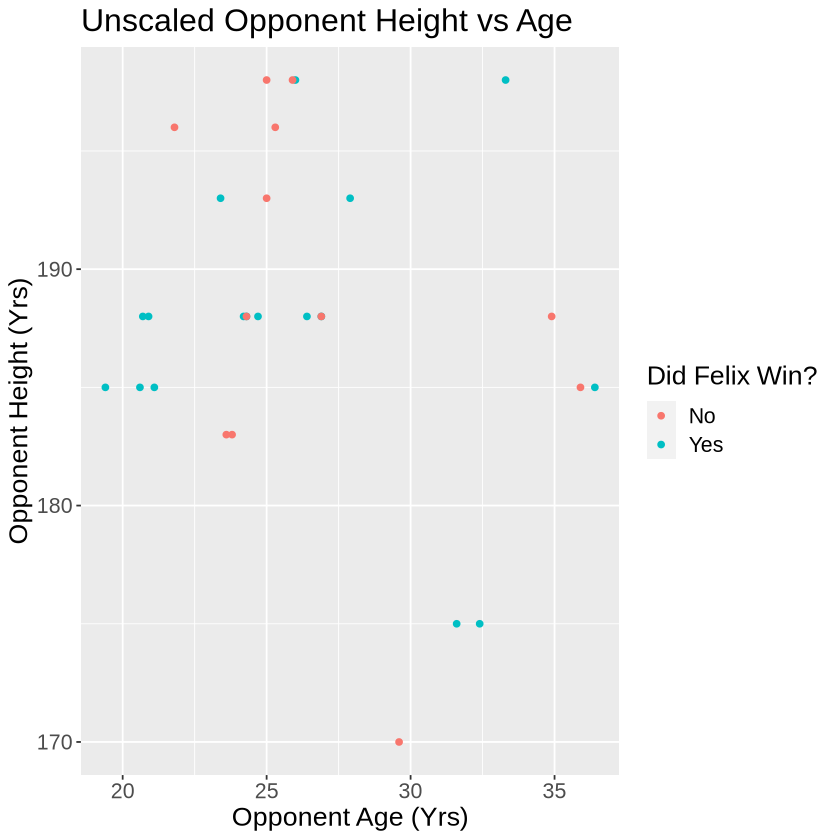

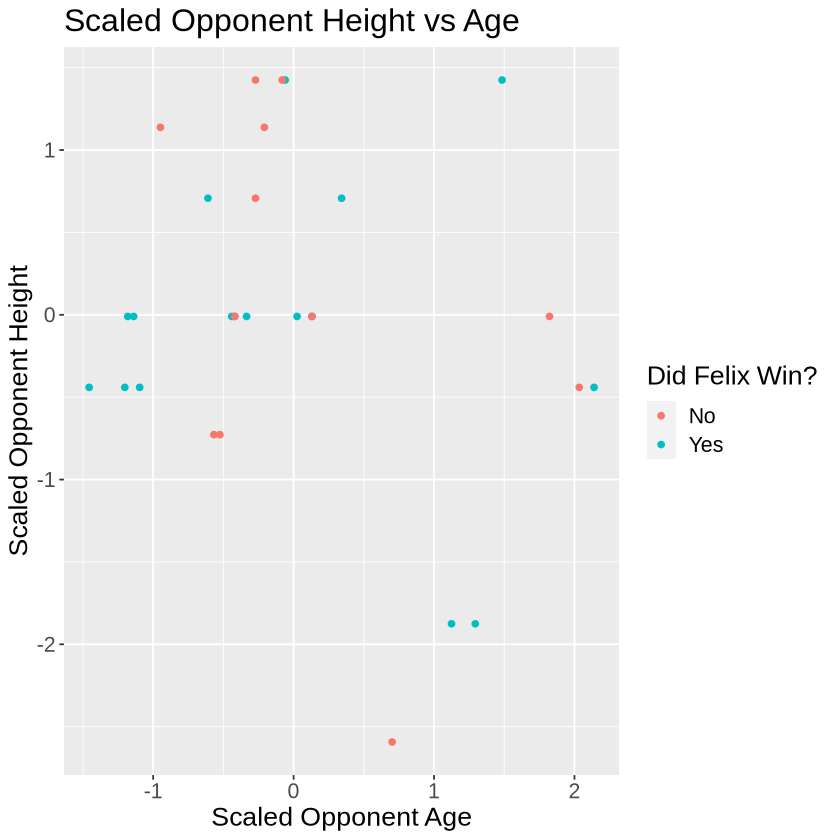

In [10]:
#Graph
plot_2022 <- tidy_tennis_data_2022 |> 
    ggplot(aes(x = opp_age, y = opp_ht, color = winner)) +
        geom_point() +
        labs(x = "Opponent Age (Yrs)", y = "Opponent Height (Yrs)", color = "Did Felix Win?", title = "Unscaled Opponent Height vs Age") + 
        theme(text = element_text(size = 16))

plot_2022

plot_2022_scaled <- tidy_tennis_data_2022_scaled |> 
    ggplot(aes(x = opp_age, y = opp_ht, color = winner)) +
        geom_point() +
        labs(x = "Scaled Opponent Age", y = "Scaled Opponent Height", color = "Did Felix Win?", title = "Scaled Opponent Height vs Age") + 
        theme(text = element_text(size = 16))

plot_2022_scaled